In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as pltc
import datetime as dt
from scipy import stats
from sklearn import preprocessing
import matplotlib as mpl
from scipy.stats import skew

## Plotting parameters
mpl.rcParams['pdf.fonttype'] = 42

## Cubic feet to cubic meters conversion factor
cfs_2_cms = 0.0283168466

Things to add
- Caluculate stats on all datasets (modeled and NWIS)
- Calculate multiple stats

In [113]:
def readModelFile(i):
    try:
        df = pd.read_csv('../data/pnwNP_modeledData/'+str(pnwNP['gage'][i])+".csv")
        df['time'] = pd.to_datetime(df['time'])
        df['climate_year'] = df.time.dt.year.where(df.time.dt.month < 4, df.time.dt.year + 1)
        df = df.drop(['Unnamed: 0'],axis=1)
        df_nwis = df[df["streamflow_NWIS"].notna()].reset_index(drop=True)
        return df,df_nwis
    except:
        pass

In [125]:
def calc7Q10(df):
    import warnings
    warnings.filterwarnings("ignore")
    '''
    Read in data files for gages and calculate frequency statistics.
    '''
    

    stat = "7Q10"
    columns = ["gage","VIC_"+stat,"PRMS_"+stat,"NWM2d0_"+stat,"NWM2d1_"+stat,"NWIS_"+stat]
    out = []

    for column in df[["streamflow_VIC","streamflow_PRMS",'streamflow_NWM2d0','streamflow_NWM2d1','streamflow_NWIS']]:

        ## Calculate 7-day rolling average 
        df['7Q10'] = df[column].rolling(window=7).mean()


        lf7q10 = df[['climate_year','7Q10']]
        lf7q10 = lf7q10.groupby(['climate_year']).min()
        lf7q10 = lf7q10[df['7Q10'].isnull().groupby(df['climate_year']).sum() <= 36.6] ## makes sure that gage has at least 90% of year with data

        lf7q10["RI"] = (1+len(lf7q10))/lf7q10['7Q10'].rank(method = "min")
        lf7q10["ExcProb"] = 1/lf7q10["RI"]


        #Measures of the distribution
        Xbar = np.mean(np.log10(lf7q10['7Q10']))
        S = np.std(np.log10(lf7q10['7Q10']))
        g = skew(np.log10(lf7q10['7Q10']))

        ## Calculate Pearson type 3 coeff 
        lf7q10["z"] = 4.91 * ((1 / lf7q10["RI"])**0.14 -(1 - 1 / lf7q10["RI"])**0.14)
        lf7q10["K"] = (2/g) * ((((lf7q10["z"] - (g/6))*(g/6)+1)**3)-1)
        lf7q10["Qfit"] = 10**(Xbar + (lf7q10["K"] * S))

        ## Calculate 7q#
        RetIntCalc = 10
        z = 4.91 * ((1 / RetIntCalc)**0.14 -(1 - 1 / RetIntCalc)**0.14)
        K = (2/g) * ((((z - (g/6))*(g/6)+1)**3)-1)
        calc7q10 = 10**(Xbar + (K * S))
        out.extend([calc7q10])

    out.insert(0,int(df["gage"][0]))
    out = pd.DataFrame(out).transpose()
    out.columns = columns
    return out


In [126]:
pnwNP = pd.read_csv("../data/pnwNP_StatsLocations_SS.csv")

stat = "7Q10"
columns = ["gage","VIC_"+stat,"PRMS_"+stat,"NWM2d0_"+stat,"NWM2d1_"+stat,"NWIS_"+stat]
nwis_df = pd.DataFrame(columns=columns)
main_df = pd.DataFrame(columns=columns)

from tqdm import tqdm
for i in tqdm(range(len(pnwNP)+1)):
    try:
        df,df_nwis = readModelFile(i)
        nwis_df = pd.concat([nwis_df, calc7Q10(df_nwis)], axis=0)
        main_df = pd.concat([main_df, calc7Q10(df)], axis=0)
    except:
        pass

100%|█████████████████████████████████████████| 619/619 [00:30<00:00, 20.47it/s]


In [116]:
nwis_df = nwis_df.reset_index(drop=True)
nwis_df.to_csv("../data/stat7q10_nwisPeriod.csv")

main_df = main_df.reset_index(drop=True)
main_df.to_csv("../data/stat7q10_entirePeriod.csv")

<Axes: xlabel='VIC7Q10', ylabel='NWIS_7Q10'>

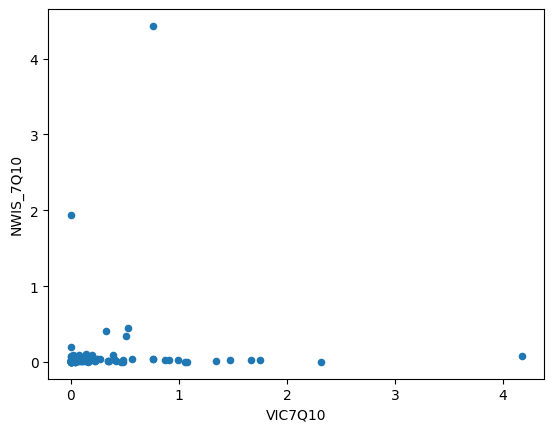

In [123]:
main_df.plot.scatter(x = "VIC7Q10",y = "NWIS_7Q10")

In [118]:
main_df = main_df.reset_index(drop=True)
# main_df["gage"] = str(main_df["gage"])
main_df.loc[main_df["NWIS_7Q10"].idxmax()]

gage           1.251400e+07
VIC7Q10                 NaN
PRMS_7Q10               NaN
NWM2d0_7Q10    7.761391e+02
NWM2d1_7Q10    9.789042e+02
NWIS_7Q10      1.555707e+03
Name: 177, dtype: float64

In [119]:
main_df["NWIS_7Q10"].idxmax()

177

In [120]:
main_df = pd.read_csv("../data/stat7q10_entirePeriod.csv").drop(["Unnamed: 0"],axis=1)
main_df

,gage,VIC7Q10,PRMS_7Q10,NWM2d0_7Q10,NWM2d1_7Q10,NWIS_7Q10
0,1.036170e+07,NaN,NaN,NaN,NaN,NaN
1,1.036600e+07,NaN,NaN,0.143569,0.032770,0.033906
2,1.037850e+07,1.075685,0.135996,0.178535,0.549004,0.004047
3,1.038950e+07,NaN,NaN,0.789689,1.615650,NaN
4,1.039000e+07,NaN,NaN,0.789689,1.615650,0.030314
...,...,...,...,...,...,...
489,1.437200e+07,NaN,NaN,0.021886,NaN,0.022221
490,1.437540e+07,NaN,NaN,0.041887,NaN,0.027121
491,4.332471e+14,NaN,NaN,0.574855,0.689181,NaN
492,4.527551e+14,NaN,NaN,NaN,NaN,0.000277


In [121]:
main_df.loc[main_df.notna().all(axis='columns')]

,gage,VIC7Q10,PRMS_7Q10,NWM2d0_7Q10,NWM2d1_7Q10,NWIS_7Q10
2,10378500.0,1.075685,0.135996,0.178535,0.549004,0.004047
5,10393500.0,4.171246,0.904580,1.370077,0.569489,0.082358
9,10403000.0,1.059367,0.117038,0.322014,0.110506,0.004900
10,10406500.0,0.076999,0.488920,0.010033,0.012812,0.030595
13,12030000.0,0.205141,0.076081,0.056309,0.071133,0.024673
...,...,...,...,...,...,...
466,14314500.0,0.267263,0.093909,0.072593,0.650985,0.033852
471,14320700.0,0.993453,0.420939,0.456489,0.157644,0.030755
477,14337800.0,0.562918,0.182168,0.159430,0.174999,0.037307
478,14337830.0,0.758398,0.234803,0.218654,0.237127,0.036491


In [122]:
nwis_df = nwis_df.reset_index(drop=True)
nwis_df.loc[nwis_df.notna().all(axis='columns')]

,gage,VIC7Q10,PRMS_7Q10,NWM2d0_7Q10,NWM2d1_7Q10,NWIS_7Q10
5,10393500.0,4.145377e+00,0.981417,1.573767,0.726548,0.082859
53,12113347.0,8.109013e-02,0.015257,0.070739,0.092954,0.016003
57,12116500.0,5.331159e-01,0.421862,0.924332,1.022638,0.442543
67,12128000.0,2.484039e-01,0.026972,0.206633,0.279552,0.046389
75,12157250.0,3.331989e-02,0.021765,0.023415,0.035734,0.011968
76,12158010.0,7.004907e-02,0.031219,0.045382,0.064643,0.054951
87,12201950.0,4.015174e-02,0.012437,0.037824,0.009131,0.002357
90,12202300.0,3.336477e-02,0.013261,0.029374,0.009727,0.004590
96,12323700.0,3.262630e-02,0.234849,0.195983,0.157725,0.014226
98,12323770.0,6.655383e-02,0.672585,0.953107,0.613374,0.033742
